In [ ]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
from sklearn.metrics import root_mean_squared_error, mean_squared_error, accuracy_score, roc_auc_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
import sklearn.model_selection
import sklearn.datasets
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.neural_network import MLPRegressor
from typing import Tuple, List, Any, Dict, Union
import optuna
import pickle
import warnings
warnings.filterwarnings("ignore")

SEED = 17
compare_metric_name = 'RMSE'

## Utils

In [ ]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    return df

In [2]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: Any, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: sklearn.metrics = root_mean_squared_error) -> Tuple[List[float], List[float]]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (Any): algorithm to use for training and prediction
        cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[List[float], List[float]]: Tuple of lists of train and validation scores
    """
    train_scores, validation_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred))
        validation_scores.append(metric(y_val, y_val_pred))
    return train_scores, validation_scores

def evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: Any, metric: sklearn.metrics = root_mean_squared_error) -> Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (Any): algorithm to use for training and prediction
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    train_results = metric(y_train, y_train_pred)
    test_results = metric(y_test, y_test_pred)
    return train_results, test_results, y_test_pred

# Load dataset

In [3]:
data = read_table_from_db('airbnb_data')
target_feature = 'log_price'
categorical_features = data.columns[data.nunique() == 2].tolist()
continuous_features = data.columns.drop(categorical_features + [target_feature]).tolist()
independent_features = continuous_features + categorical_features
data.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,...,number_of_education_institutions_within_100m,distance_to_nearest_cultural_institution_m,number_of_cultural_institutions_within_100m,distance_to_nearest_recreation_point_m,number_of_recreation_points_within_100m,distance_to_nearest_religious_institution_m,number_of_religious_institutions_within_100m,distance_to_nearest_health_institution_m,number_of_health_institutions_within_100m,distance_to_nearest_main_attraction_m
0,0,1,1,1,0.0,1.0,30,1125,0,248,...,0,264.899,0,74.9974,1,113.311,0,748.997,0,497.315
1,0,1,1,2,1.0,1.0,30,150,0,233,...,1,114.917,0,157.0960,0,143.338,0,798.512,0,5687.510
2,0,1,1,4,2.0,2.0,30,730,0,121,...,1,419.009,0,375.3300,0,201.431,0,607.539,0,5139.470
3,1,1,1,3,2.0,1.0,30,730,0,157,...,1,441.078,0,122.0370,0,489.013,0,867.072,0,5022.830
4,0,1,1,1,1.0,1.0,30,180,30,365,...,0,571.057,0,108.9370,0,157.284,0,262.918,0,2800.150


## Split dataset

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

## Base model

In [5]:
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train RMSE: 3.1555 +- 2.0791
Validation RMSE: 3.1960 +- 2.0395


Neural networks are algorithms that are sensitive to the scale of data.

In a situation where the data is not normalized, the algorithm may have trouble finding the optimal weights.

This happens because when we multiply the data by the weights, the resulting matrices will have different values, which can lead to optimization problems.

We will use and compare several scaling methods to test whether the results will improve.

In [6]:
def perform_cv_scaling(X: pd.DataFrame, y: pd.Series, algorithm: Any, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: sklearn.metrics = root_mean_squared_error, scaler: sklearn.preprocessing = None, features_to_scale: List[str] = None, target_to_scale: bool = False) -> Tuple[List[float], List[float]]:
    """
    Perform cross-validation with scaling and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (Any): algorithm to use for training and prediction
        cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
        scaler (sklearn.preprocessing, default=None): scaler to use
        features_to_scale (List[str], default=None): list of features to scale
        target_to_scale (bool, default=False): whether to scale target
    
    Returns:
        Tuple[List[float], List[float]]: Tuple of lists of train and validation scores
    """
    train_scores, validation_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])
        if target_to_scale:
            y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_val = scaler.transform(y_val.values.reshape(-1, 1)).ravel()    
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        if(target_to_scale):
            y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
            y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
            y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
            y_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).ravel()
        train_scores.append(metric(y_train, y_train_pred))
        validation_scores.append(metric(y_val, y_val_pred))
    return train_scores, validation_scores

def evaluation_scaling(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: Any, metric: sklearn.metrics = root_mean_squared_error, scaler: sklearn.preprocessing = None, features_to_scale: List[str] = None, target_to_scale: bool = False) -> Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data with scaling and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (Any): algorithm to use for training and prediction
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
        scaler (sklearn.preprocessing, default=None): scaler to use
        features_to_scale (List[str], default=None): list of features to scale
        target_to_scale (bool, default=False): whether to scale target
    
    Returns:
        Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    if target_to_scale:
        y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    if target_to_scale:
        y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
        y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
        y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    train_results = metric(y_train, y_train_pred)
    test_results = metric(y_test, y_test_pred)
    return train_results, test_results, y_test_pred

In [7]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "QuantileTransformer": QuantileTransformer()
}
for scaler_name, scaler in scalers.items():
    train_scores, validation_scores = perform_cv_scaling(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=continuous_features, target_to_scale=False)
    print(f"{scaler_name}:")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores)}")
    print()

StandardScaler:
Train RMSE: 0.2799 +- 0.0079
Validation RMSE: 0.4596 +- 0.005106693589066525

MinMaxScaler:
Train RMSE: 0.3078 +- 0.0087
Validation RMSE: 0.4610 +- 0.008429642955367054

RobustScaler:
Train RMSE: 0.2957 +- 0.0163
Validation RMSE: 0.4525 +- 0.004602876458793384

QuantileTransformer:
Train RMSE: 0.3017 +- 0.0043
Validation RMSE: 0.4790 +- 0.008284450296654576



As we can see after applying any of the scaling methods, the results are better than before.

Best validation scores are obtained for RobustScaler which I will use in the next steps.

We can check the results once again after applying the RobustScaler.

In [8]:
model = MLPRegressor(random_state=SEED)
scaler = RobustScaler()
train_scores, validation_scores = perform_cv_scaling(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=continuous_features, target_to_scale=False)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores)}")

Train RMSE: 0.2957 +- 0.0163
Validation RMSE: 0.4525 +- 0.004602876458793384


In [9]:
hidden_layer_sizes = [(20, 20)]
for hidden_layer_size in hidden_layer_sizes:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(independent_features)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(continuous_features), target_to_scale=False)
    print(f"Hidden layer sizes: {hidden_layer_size}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores)}\n")

Hidden layer sizes: (20, 20)
Train RMSE: 0.3679 +- 0.0026
Validation RMSE: 0.4244 +- 0.005529944953902177



## Feature selection

Although we have not selected features for XGBoost (which is a tree based model that select features by itself), for neural network it might be beneficial to reduce the number of features.

We will use Mutual Information to select the most important features.

The algorithm will look as follows:

1. Calculate the mutual information between each feature and the target.

2. Sort the features by the mutual information in descending order.

3. Select top:
- 25% of features
- 50% of features
- 75% of features
- 90% of features
- 100% of features

For each subset of features, we will train the model and compare the results.

4. Compare the results and select the best subset of features.

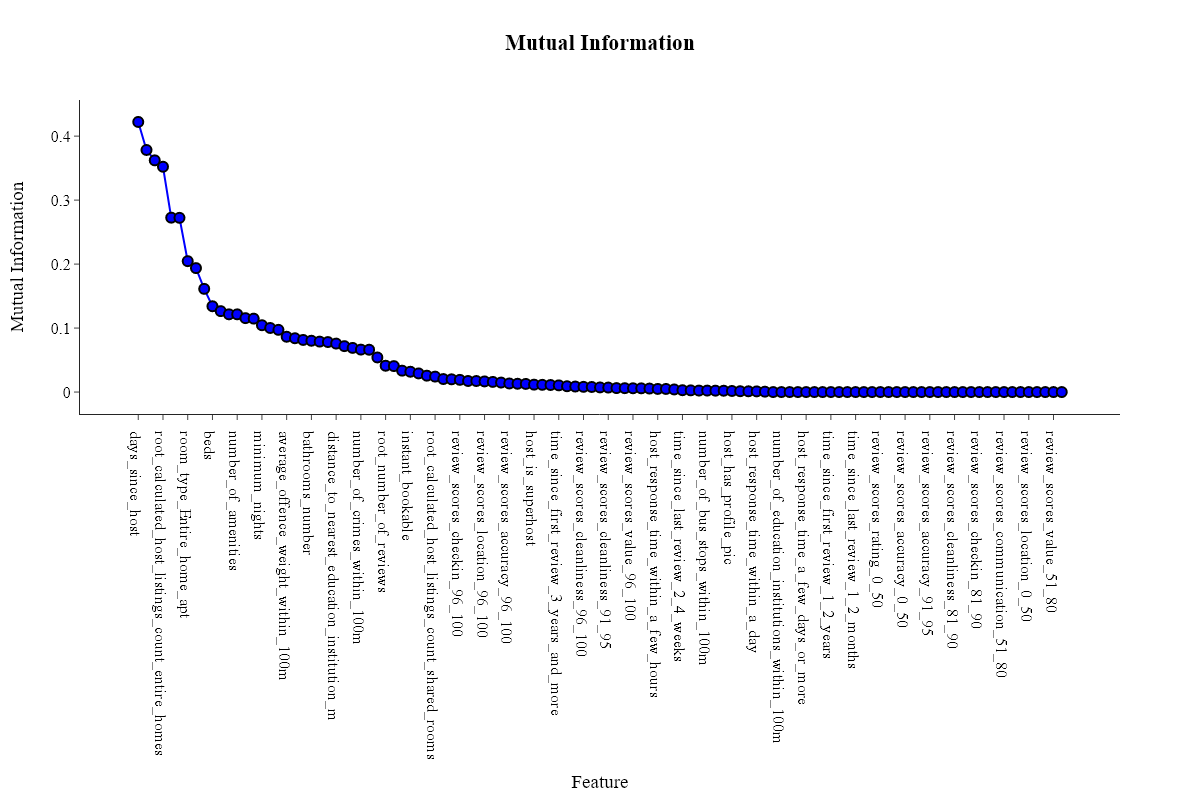

In [10]:
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
mi_scores = {feature: mutual_info_regression(train_data[[feature]], train_data[target_feature], random_state=SEED)[0] for feature in independent_features}
mi_scores = {k: v for k, v in sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(mi_scores.keys()), y=list(mi_scores.values()), mode='lines+markers', marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

In [11]:
avg_train_scores, avg_validation_scores, percentages = [], [], []
proportions_of_subset = [1.0, 0.75, 0.5, 0.25, 0.1]
for proportion in proportions_of_subset:
    threshold = np.quantile(list(mi_scores.values()), 1-proportion)
    features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
    subset = set(independent_features) - set(features_to_drop)
    features_to_scale = subset - set(categorical_features)
    model = MLPRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Percentage of features: {len(subset)/len(independent_features)*100:.2f}%")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")
    avg_train_scores.append(np.mean(train_scores))
    avg_validation_scores.append(np.mean(validation_scores))
    percentages.append(np.round(len(subset)/len(independent_features)*100, 2))

Percentage of features: 100.00%
Train RMSE: 0.2933 +- 0.0094
Validation RMSE: 0.4583 +- 0.0029

Percentage of features: 100.00%
Train RMSE: 0.2933 +- 0.0094
Validation RMSE: 0.4583 +- 0.0029

Percentage of features: 50.44%
Train RMSE: 0.3526 +- 0.0105
Validation RMSE: 0.4359 +- 0.0105

Percentage of features: 25.66%
Train RMSE: 0.4056 +- 0.0064
Validation RMSE: 0.4565 +- 0.0104

Percentage of features: 10.62%
Train RMSE: 0.4740 +- 0.0015
Validation RMSE: 0.4898 +- 0.0074



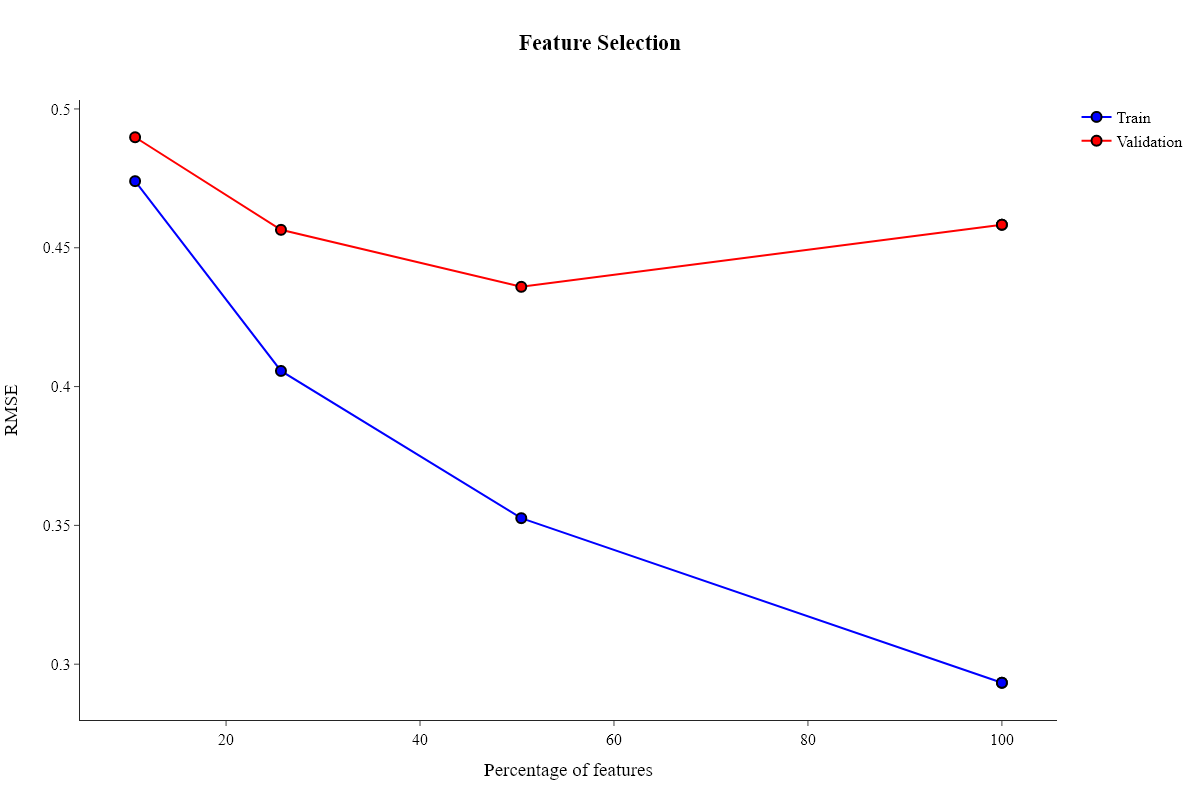

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=percentages, y=avg_train_scores, mode='lines+markers', name="Train", marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.add_trace(go.Scatter(x=percentages, y=avg_validation_scores, mode='lines+markers', name="Validation", marker=dict(size=10, color="red", line=dict(width=2, color="black")), line=dict(width=2, color="red")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Feature Selection<b>", title_x=0.5, xaxis_title="Percentage of features", yaxis_title="RMSE", font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

As we can see selecting only 50.44% features (those which exceeds the 50th percentile of mutual information) gives better validation score than using all features.

We will further investigate range of features from 30th to 70th percentile of mutual information.

In [13]:
avg_train_scores, avg_validation_scores, percentages = [], [], []
proportions_of_subset = [0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3]
for proportion in proportions_of_subset:
    threshold = np.quantile(list(mi_scores.values()), 1-proportion)
    features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
    subset = set(independent_features) - set(features_to_drop)
    features_to_scale = subset - set(categorical_features)
    model = MLPRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Percentage of features: {len(subset)/len(independent_features)*100:.2f}%")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")
    avg_train_scores.append(np.mean(train_scores))
    avg_validation_scores.append(np.mean(validation_scores))
    percentages.append(np.round(len(subset)/len(independent_features)*100, 2))

Percentage of features: 100.00%
Train RMSE: 0.2933 +- 0.0094
Validation RMSE: 0.4583 +- 0.0029

Percentage of features: 64.60%
Train RMSE: 0.3222 +- 0.0055
Validation RMSE: 0.4329 +- 0.0042

Percentage of features: 60.18%
Train RMSE: 0.3230 +- 0.0059
Validation RMSE: 0.4368 +- 0.0071

Percentage of features: 54.87%
Train RMSE: 0.3314 +- 0.0069
Validation RMSE: 0.4377 +- 0.0047

Percentage of features: 50.44%
Train RMSE: 0.3526 +- 0.0105
Validation RMSE: 0.4359 +- 0.0105

Percentage of features: 45.13%
Train RMSE: 0.3508 +- 0.0050
Validation RMSE: 0.4335 +- 0.0037

Percentage of features: 39.82%
Train RMSE: 0.3736 +- 0.0055
Validation RMSE: 0.4409 +- 0.0065

Percentage of features: 35.40%
Train RMSE: 0.3755 +- 0.0148
Validation RMSE: 0.4414 +- 0.0109

Percentage of features: 30.09%
Train RMSE: 0.3878 +- 0.0214
Validation RMSE: 0.4442 +- 0.0174



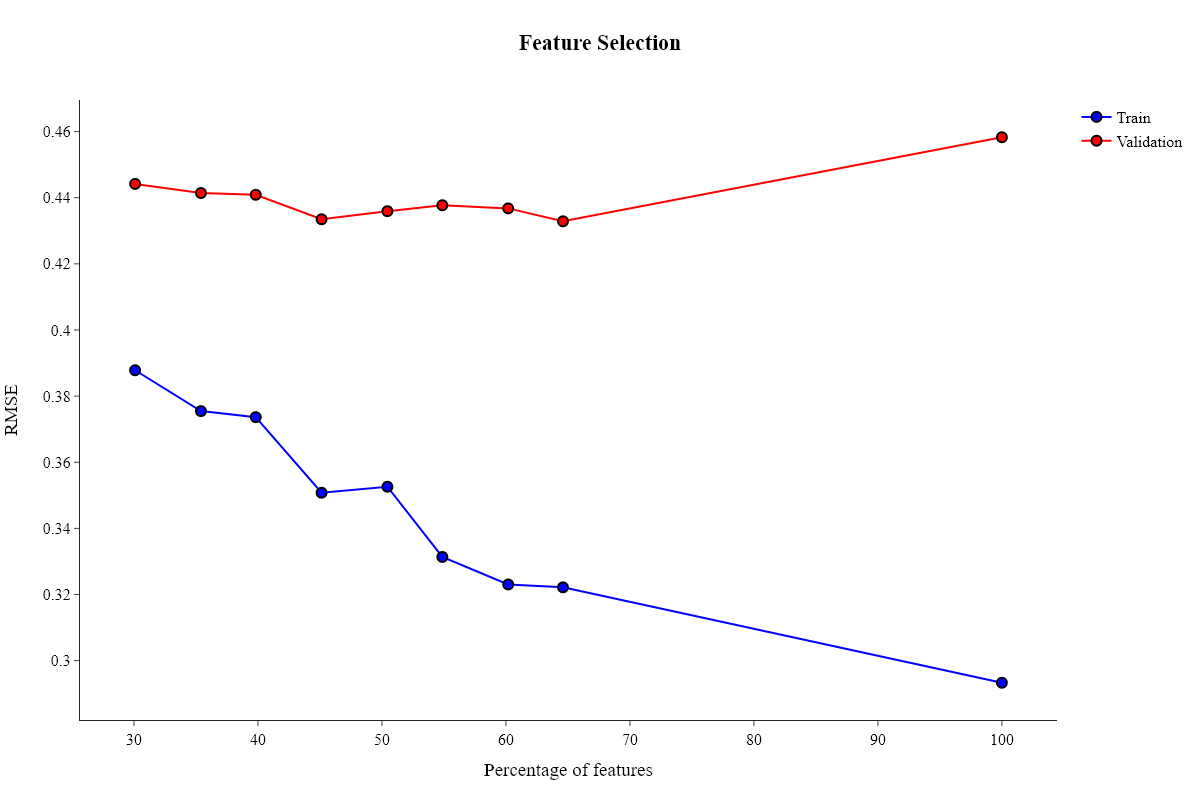

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=percentages, y=avg_train_scores, mode='lines+markers', name="Train", marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.add_trace(go.Scatter(x=percentages, y=avg_validation_scores, mode='lines+markers', name="Validation", marker=dict(size=10, color="red", line=dict(width=2, color="black")), line=dict(width=2, color="red")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Feature Selection<b>", title_x=0.5, xaxis_title="Percentage of features", yaxis_title="RMSE", font=dict(family="Times New Roman",size=16,color="Black"))
fig.show("png")

It looks like the best average validation score is obtained for ~50% best (based on Mutual Information) features, so we will use this subset of variables for further analysis.

In [15]:
proportion_of_subset = 0.5
threshold = np.quantile(list(mi_scores.values()), 1-proportion_of_subset)
features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
best_subset = set(independent_features) - set(features_to_drop)
features_to_scale = best_subset - set(categorical_features)
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
print(f"Percentage of features: {len(best_subset)/len(independent_features)*100:.2f}%")
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Percentage of features: 50.44%
Train RMSE: 0.3526 +- 0.0105
Validation RMSE: 0.4359 +- 0.0105


There is still room for improvement, so we will try to tune the hyperparameters of the model.

# Hyperparameter optimization

## `hidden_layer_sizes`

`hidden_layer_sizes` is a parameter that defines the number of neurons in each layer and the number of layers in the model.

In [16]:
hidden_layer_sizes = [i for i in range(20, 201, 30)]
for hidden_layer_size in hidden_layer_sizes:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Hidden layer sizes: {hidden_layer_size}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Hidden layer sizes: 20
Train RMSE: 0.3972 +- 0.0014
Validation RMSE: 0.4241 +- 0.0042

Hidden layer sizes: 50
Train RMSE: 0.3800 +- 0.0129
Validation RMSE: 0.4317 +- 0.0106

Hidden layer sizes: 80
Train RMSE: 0.3593 +- 0.0114
Validation RMSE: 0.4361 +- 0.0091

Hidden layer sizes: 110
Train RMSE: 0.3517 +- 0.0215
Validation RMSE: 0.4493 +- 0.0218

Hidden layer sizes: 140
Train RMSE: 0.3323 +- 0.0100
Validation RMSE: 0.4426 +- 0.0082

Hidden layer sizes: 170
Train RMSE: 0.3193 +- 0.0082
Validation RMSE: 0.4430 +- 0.0057

Hidden layer sizes: 200
Train RMSE: 0.3071 +- 0.0264
Validation RMSE: 0.4609 +- 0.0145



The higher the number of neurons, the more complex the model will be and the more likely it will overfit.

Based on above scores optimal number of neurons is 80, but I will try to make some more layers (currently only 1 layer is used).

In [17]:
hidden_layer_sizes = [(20, 20), (50, 50), (80, 80), (20, 20, 20), (50, 50, 50), (80, 80, 80)]
for hidden_layer_size in hidden_layer_sizes:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Hidden layer sizes: {hidden_layer_size}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Hidden layer sizes: (20, 20)
Train RMSE: 0.3933 +- 0.0041
Validation RMSE: 0.4293 +- 0.0064

Hidden layer sizes: (50, 50)
Train RMSE: 0.3277 +- 0.0062
Validation RMSE: 0.4387 +- 0.0082

Hidden layer sizes: (80, 80)
Train RMSE: 0.2724 +- 0.0095
Validation RMSE: 0.4668 +- 0.0034

Hidden layer sizes: (20, 20, 20)
Train RMSE: 0.3828 +- 0.0098
Validation RMSE: 0.4334 +- 0.0094

Hidden layer sizes: (50, 50, 50)
Train RMSE: 0.2962 +- 0.0080
Validation RMSE: 0.4584 +- 0.0058

Hidden layer sizes: (80, 80, 80)
Train RMSE: 0.2262 +- 0.0164
Validation RMSE: 0.4900 +- 0.0096



As we can see higher number of layers leads to overfitting.

Currently I will stick to 1 layer and try to tune number of neurons in smaller range of [30, 80].

In [18]:
hidden_layer_sizes = [i for i in range(30, 81, 10)]
for hidden_layer_size in hidden_layer_sizes:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Hidden layer sizes: {hidden_layer_size}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Hidden layer sizes: 30
Train RMSE: 0.3931 +- 0.0014
Validation RMSE: 0.4302 +- 0.0058

Hidden layer sizes: 40
Train RMSE: 0.3831 +- 0.0083
Validation RMSE: 0.4310 +- 0.0061

Hidden layer sizes: 50
Train RMSE: 0.3800 +- 0.0129
Validation RMSE: 0.4317 +- 0.0106

Hidden layer sizes: 60
Train RMSE: 0.3704 +- 0.0070
Validation RMSE: 0.4289 +- 0.0034

Hidden layer sizes: 70
Train RMSE: 0.3736 +- 0.0288
Validation RMSE: 0.4417 +- 0.0247

Hidden layer sizes: 80
Train RMSE: 0.3593 +- 0.0114
Validation RMSE: 0.4361 +- 0.0091



Best validation score is obtained for 60 neurons.

In [16]:
best_hidden_layer_sizes = 60

## `activation`

`activation` is a parameter that defines the activation function for the hidden layer.

In [20]:
activations = ['identity', 'logistic', 'tanh', 'relu']
for activation in activations:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=activation, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Activation: {activation}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Activation: identity
Train RMSE: 0.5054 +- 0.0183
Validation RMSE: 0.5081 +- 0.0244

Activation: logistic
Train RMSE: 0.3646 +- 0.0022
Validation RMSE: 0.4115 +- 0.0049

Activation: tanh
Train RMSE: 0.3517 +- 0.0025
Validation RMSE: 0.4238 +- 0.0052

Activation: relu
Train RMSE: 0.3704 +- 0.0070
Validation RMSE: 0.4289 +- 0.0034



Best values were obtained for logistic activation function.

In [17]:
best_activation = 'logistic'

## `solver`

`solver` is a parameter that defines the optimization algorithm for the model.

In [22]:
solvers = ['lbfgs', 'sgd', 'adam']
for solver in solvers:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=solver, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Solver: {solver}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Solver: lbfgs
Train RMSE: 0.4092 +- 0.0020
Validation RMSE: 0.4220 +- 0.0065

Solver: sgd
Train RMSE: 0.4757 +- 0.0032
Validation RMSE: 0.4778 +- 0.0077

Solver: adam
Train RMSE: 0.3646 +- 0.0022
Validation RMSE: 0.4115 +- 0.0049



As we can see the best validation score is obtained for `adam` solver.

In [18]:
best_solver = 'adam'

## `alpha`

`alpha` is a parameter that defines the regularization strength for the model.

It is used to prevent overfitting by adding a penalty to the weights (L2 regularization, known as weight decay).

In [24]:
alphas = [10**i for i in range(-5, 3)]
for alpha in alphas:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver, alpha=alpha, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Alpha: {alpha}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Alpha: 1e-05
Train RMSE: 0.3644 +- 0.0022
Validation RMSE: 0.4114 +- 0.0049

Alpha: 0.0001
Train RMSE: 0.3646 +- 0.0022
Validation RMSE: 0.4115 +- 0.0049

Alpha: 0.001
Train RMSE: 0.3669 +- 0.0023
Validation RMSE: 0.4111 +- 0.0051

Alpha: 0.01
Train RMSE: 0.3822 +- 0.0026
Validation RMSE: 0.4115 +- 0.0048

Alpha: 0.1
Train RMSE: 0.4213 +- 0.0030
Validation RMSE: 0.4294 +- 0.0045

Alpha: 1
Train RMSE: 0.4883 +- 0.0019
Validation RMSE: 0.4892 +- 0.0055

Alpha: 10
Train RMSE: 0.5522 +- 0.0034
Validation RMSE: 0.5526 +- 0.0096

Alpha: 100
Train RMSE: 0.7943 +- 0.0038
Validation RMSE: 0.7942 +- 0.0147



Higher values of alpha will lead to underfitting, while lower values will lead to overfitting.

Range of alpha [0.0001, 0.01] will be tested.

In [25]:
alphas = np.linspace(0.0001, 0.01, 10)
for alpha in alphas:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver, alpha=alpha, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Alpha: {alpha}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Alpha: 0.0001
Train RMSE: 0.3646 +- 0.0022
Validation RMSE: 0.4115 +- 0.0049

Alpha: 0.0012000000000000001
Train RMSE: 0.3673 +- 0.0023
Validation RMSE: 0.4111 +- 0.0052

Alpha: 0.0023
Train RMSE: 0.3697 +- 0.0022
Validation RMSE: 0.4107 +- 0.0054

Alpha: 0.0034
Train RMSE: 0.3722 +- 0.0023
Validation RMSE: 0.4105 +- 0.0052

Alpha: 0.0045000000000000005
Train RMSE: 0.3743 +- 0.0024
Validation RMSE: 0.4105 +- 0.0051

Alpha: 0.005600000000000001
Train RMSE: 0.3762 +- 0.0024
Validation RMSE: 0.4106 +- 0.0050

Alpha: 0.0067
Train RMSE: 0.3780 +- 0.0024
Validation RMSE: 0.4108 +- 0.0051

Alpha: 0.0078000000000000005
Train RMSE: 0.3795 +- 0.0025
Validation RMSE: 0.4110 +- 0.0050

Alpha: 0.0089
Train RMSE: 0.3809 +- 0.0025
Validation RMSE: 0.4113 +- 0.0049

Alpha: 0.01
Train RMSE: 0.3822 +- 0.0026
Validation RMSE: 0.4115 +- 0.0048



Differences are marginal, but the best validation score is obtained for alpha = 0.0023.

In [19]:
best_alpha = 0.0023

## `learning_rate`

`learning_rate` is a parameter that defines the learning rate for the model, which can be defined as strength of weight updates.

In [27]:
learning_rates = [10**i for i in range(-5, 1)]
for learning_rate in learning_rates:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver, alpha=best_alpha, learning_rate_init=learning_rate, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Learning rate: {learning_rate}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Learning rate: 1e-05
Train RMSE: 0.5256 +- 0.0020
Validation RMSE: 0.5266 +- 0.0065

Learning rate: 0.0001
Train RMSE: 0.4413 +- 0.0022
Validation RMSE: 0.4463 +- 0.0048

Learning rate: 0.001
Train RMSE: 0.3697 +- 0.0022
Validation RMSE: 0.4107 +- 0.0054

Learning rate: 0.01
Train RMSE: 0.3807 +- 0.0279
Validation RMSE: 0.4356 +- 0.0275

Learning rate: 0.1
Train RMSE: 0.4978 +- 0.0658
Validation RMSE: 0.5109 +- 0.0595

Learning rate: 1
Train RMSE: 0.7042 +- 0.1423
Validation RMSE: 0.7052 +- 0.1454



Best values were obtained for default learning rate.

In [20]:
best_learning_rate = 0.001

## `max_iter`

`max_iter` is a parameter that defines the maximum number of iterations for the model.

In [29]:
max_iters = [i for i in range(100, 1001, 100)]
for max_iter in max_iters:
    model = MLPRegressor(hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver, alpha=best_alpha, learning_rate_init=best_learning_rate, max_iter=max_iter, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
    print(f"Max iterations: {max_iter}")
    print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
    print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}\n")

Max iterations: 100
Train RMSE: 0.3971 +- 0.0023
Validation RMSE: 0.4158 +- 0.0060

Max iterations: 200
Train RMSE: 0.3697 +- 0.0022
Validation RMSE: 0.4107 +- 0.0054

Max iterations: 300
Train RMSE: 0.3574 +- 0.0037
Validation RMSE: 0.4135 +- 0.0051

Max iterations: 400
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 500
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 600
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 700
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 800
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 900
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069

Max iterations: 1000
Train RMSE: 0.3561 +- 0.0045
Validation RMSE: 0.4145 +- 0.0069



As we can see there is no need to increase the number of iterations more than 300, as the results are the same.

This means that the model has already converged and increasing the number of iterations will not change the results.

It looks like the best validation score is obtained for 200 iterations.

In [21]:
best_max_iter = 200

## Automated Hyperparameter Tuning

Similarly to notebook with XGBoost model, I will use Optuna to tune the hyperparameters.

In [16]:
class RandomSearchCV:
    """
    This class is used to optimize the hyperparameters of the algorithm using Random Search.
    """

    def __init__(
        self,
        algorithm: Any,
        metric: str,
        cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED),
        n_trials: int = 100,
        seed: int = 17,
    ) -> None:
        """
        Initializes the RandomSearchCV class.

        Args:
            algorithm (Any): algorithm to use for optimization.
            metric (str): metric to use for optimization.
            cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy.
            n_trials (int): number of trials to perform.
            seed (int): random seed.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds", "maximize"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs", "maximize"],
            "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds", "minimize"],
            "rmse": [
                lambda y, y_pred: root_mean_squared_error(y, y_pred),
                "preds", "minimize"
            ],
            "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds", "minimize"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.direction = metrics[metric][2]
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed
    
    def check_X(
        self, X: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def tune(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        params_grid: Dict[str, Tuple[str, List[Any]]],
        X_valid: pd.DataFrame = None,
        y_valid: pd.Series = None,
    ) -> Dict[str, Any]:
        """
        This method tunes the algorithm hyperparameters.

        Args:
            X (pd.DataFrame): input data.
            y (pd.Series): target data.
            params_grid (Dict[str, Tuple[str, List[Any]]]): hyperparameters grid.
            X_valid (pd.DataFrame): validation data (default is None).
            y_valid (pd.Series): validation labels (default is None).

        Returns:
            Dict[str, Any]: best hyperparameters.
        """
        self.params_grid = params_grid
        study = self.create_study()
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None and y_valid is not None:
            X_valid = self.check_X(X_valid)
            y_valid = self.check_y(y_valid)
            X_valid = self.check_for_object_columns(X_valid)
            study.optimize(
                lambda trial: self.objective(trial, X, y, X_valid, y_valid),
                n_trials=self.n_trials,
            )
        else:
            study.optimize(
                lambda trial: self.objective_cv(trial, X, y),
                n_trials=self.n_trials,
            )
        return study.best_params
    
    def create_study(self,) -> optuna.study.Study:
        """This method creates an optuna study object.

        Returns:
            optuna.study.Study: optuna study object.
        """
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(direction=self.direction, sampler=sampler)
    
    def objective(self, trial: optuna.Trial, X_train: np.ndarray, y_train: np.ndarray, X_valid: np.ndarray, y_valid: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is provided.

        Args:
            trial (optuna.Trial): trial object.
            X_train (np.ndarray): input data.
            y_train (np.ndarray): target data.
            X_valid (np.ndarray): validation data.
            y_valid (np.ndarray): validation labels.
        
        Returns:
            float: Validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        return self.eval_metric(y_valid, y_valid_pred)
    
    def objective_cv(self, trial: optuna.Trial, X: np.ndarray, y: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is not provided.

        Args:
            trial (optuna.Trial): trial object.
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            float: Cross-validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        return self.perform_cv(X, y)

    
    def get_param(self, trial: optuna.Trial, param_name: str, param_values: Tuple[str, List[Any]]) -> Any:
        """
        This method converts the parameter values to the optuna parameter suggestion.

        Args:
            trial (optuna.Trial): trial object.
            param_name (str): parameter name.
            param_values (Tuple[str, List[Any]]): parameter values.

        Returns:
            typing.Any: parameter suggestion.
        """
        param_type, param_value = param_values
        if param_type == "int":
            return trial.suggest_int(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "float":
            return trial.suggest_float(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "categorical":
            return trial.suggest_categorical(param_name, param_value)
        elif param_type == "constant":
            return trial.suggest_categorical(param_name, [param_value])

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        valid_scores = []
        for train_idx, valid_idx in self.cv.split(X):
            X_train_cv, X_valid_cv = X[train_idx], X[valid_idx]
            y_train_cv, y_valid_cv = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train_cv, y_train_cv)
            if self.metric_type == "preds":
                y_valid_pred = self.algorithm.predict(X_valid_cv)
            else:
                y_valid_pred = self.algorithm.predict_proba(X_valid_cv)[:, 1]
            valid_scores.append(self.eval_metric(y_valid_cv, y_valid_pred))
        return np.mean(valid_scores)

In [ ]:
params_grid = {
    "hidden_layer_sizes": ("int", [10, 100]),
    "activation": ("categorical", ["logistic", "tanh", "relu"]),
    "solver": ("categorical", ["lbfgs", "adam"]),
    "alpha": ("float", [1e-4, 1e-1]),
    "learning_rate_init": ("float", [1e-5, 1e-1]),
    "max_iter": ("int", [100, 300]),
}
CV = RandomSearchCV(
    algorithm=MLPRegressor(random_state=SEED),
    metric="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    n_trials=100,
    seed=SEED,
)
train_data_scaled = train_data.copy()
train_data_scaled[list(continuous_features)] = scaler.fit_transform(train_data_scaled[list(continuous_features)])
best_params = CV.tune(train_data_scaled[list(best_subset)], train_data_scaled[target_feature], params_grid)

[I 2025-01-16 18:34:54,078] A new study created in memory with name: no-name-43b2ceaa-f6ef-48c3-b0e7-080553cf9614
[I 2025-01-16 18:35:14,357] Trial 0 finished with value: 0.4437284546502081 and parameters: {'hidden_layer_sizes': 36, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.06378833751475922, 'learning_rate_init': 0.057564533346365875, 'max_iter': 107}. Best is trial 0 with value: 0.4437284546502081.
[I 2025-01-16 18:36:01,855] Trial 1 finished with value: 0.4212630620007455 and parameters: {'hidden_layer_sizes': 42, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.06527661968501892, 'learning_rate_init': 0.05517961934980119, 'max_iter': 220}. Best is trial 1 with value: 0.4212630620007455.
[I 2025-01-16 18:36:19,888] Trial 2 finished with value: 0.46327346833419136 and parameters: {'hidden_layer_sizes': 54, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.04190659009605311, 'learning_rate_init': 0.014398953038325035, 'max_iter': 130}. Best is trial 1 with value:

# Evaluate model

In [28]:
#Base model
model = MLPRegressor(random_state=SEED)
base_train_scores, base_validation_scores = perform_cv_scaling(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=continuous_features, target_to_scale=False)
train_score, base_test_score, y_test_pred = evaluation_scaling(train_data[independent_features], train_data[target_feature], test_data[independent_features], test_data[target_feature], model, root_mean_squared_error, scaler, continuous_features, False)

#Tuned model
model = MLPRegressor(random_state=SEED, hidden_layer_sizes=best_hidden_layer_sizes, activation=best_activation, solver=best_solver, alpha=best_alpha, learning_rate_init=best_learning_rate, max_iter=best_max_iter)
tuned_train_scores, tuned_validation_scores = perform_cv_scaling(train_data[list(best_subset)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=False)
tuned_train_score, tuned_test_score, tuned_y_test_pred = evaluation_scaling(train_data[list(best_subset)], train_data[target_feature], test_data[list(best_subset)], test_data[target_feature], model, root_mean_squared_error, scaler, features_to_scale=list(features_to_scale), target_to_scale=False)

results = pd.DataFrame({'model': ['Base', 'Tuned'], f'Train {compare_metric_name}': [np.mean(base_train_scores), np.mean(tuned_train_scores)], f'Validation {compare_metric_name}': [np.mean(base_validation_scores), np.mean(tuned_validation_scores)], f'Test {compare_metric_name}': [base_test_score, tuned_test_score]})
results.style.background_gradient(cmap='Reds', axis=0)

,model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.295683,0.452497,0.451437
1,Tuned,0.372270,0.411468,0.407244


## Save model

In [29]:
test_indices = test_data.index
model_NN = {
    "name": "Neural Network",
    "train_results": tuned_train_score,
    "test_results": tuned_test_score,
    "predictions": tuned_y_test_pred,
    "indices": test_indices
}
with open('saved_models/model_NN.pkl', 'wb') as f:
    pickle.dump(model_NN, f)